Import packages and define some variables

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sys
import seaborn as sns
import scipy as sp
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.metrics import mean_squared_error, median_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import Ridge
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline

RANDOM_STATE=42

Define a small utility function

In [2]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

# Data preprocessing

In [3]:
data = pd.read_csv("data/data_untreated.csv", index_col=0)

In [4]:
data.describe()

,cgd,cpi,gdp,unemployment,suicides,population
count,681.000000,1479.000000,1.644000e+03,1577.000000,1654.000000,1.654000e+03
mean,56.676592,82.994576,7.143152e+05,8.794356,2929.029625,2.229644e+07
std,36.814464,23.962311,2.804038e+06,5.541547,7170.830242,4.196167e+07
min,3.675330,1.627491,4.364325e+02,0.300000,0.000000,2.380100e+04
25%,30.306790,71.519895,1.146569e+04,5.100000,139.000000,2.044640e+06
50%,49.776964,86.109598,3.455280e+04,7.600000,589.500000,5.547578e+06
75%,75.539374,100.000000,1.379862e+05,11.000000,2240.250000,2.087673e+07
max,195.992700,250.829327,2.829092e+07,37.299999,60548.000000,2.977497e+08


### Correlations

Checking correlations between all variables

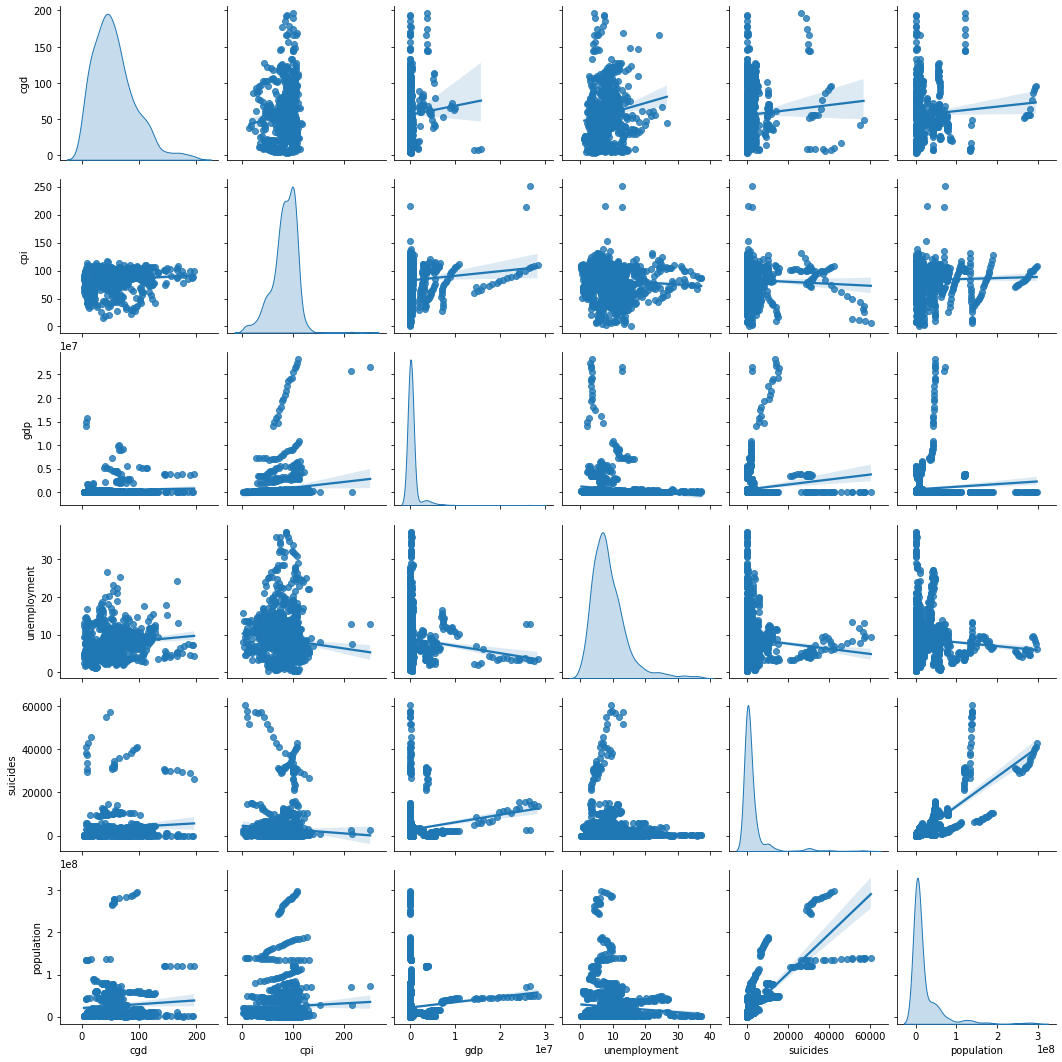

In [5]:
sns.pairplot(data, kind='reg', diag_kind='kde')

The suicides graph (our target variable) has a very long tail.

This equates to a lot of outliers. 

Datapoints where the number of suicides is >10000 will be dropped.

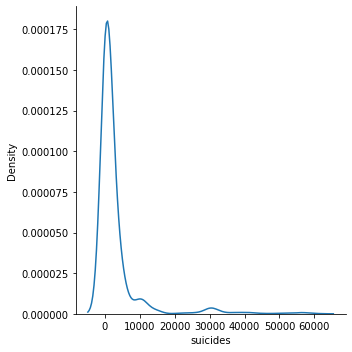

In [6]:
sns.displot(data, x='suicides', kind="kde")
nr_dps_old = data.shape[0]

7.255139056831923


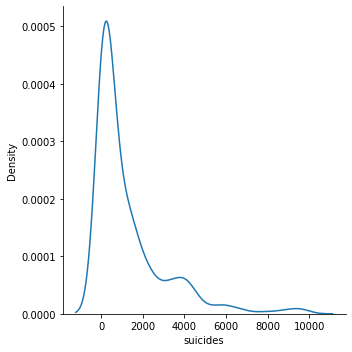

In [7]:
data = data[data['suicides'] < 10000]
sns.displot(data, x='suicides', kind="kde")
nr_dps = data.shape[0]
print(((nr_dps_old - nr_dps) / nr_dps_old) * 100)

Distribution is still trimodal and long tailed, although slightly cleaner.

Trimming cost roughly 7% of original dataset

#### Bonus
Checking linear relationship between unemployment rates and percentage of population who committed suicide

array([[<AxesSubplot:xlabel='unemployment', ylabel='unemployment'>,
        <AxesSubplot:xlabel='suicides', ylabel='unemployment'>],
       [<AxesSubplot:xlabel='unemployment', ylabel='suicides'>,
        <AxesSubplot:xlabel='suicides', ylabel='suicides'>]], dtype=object)

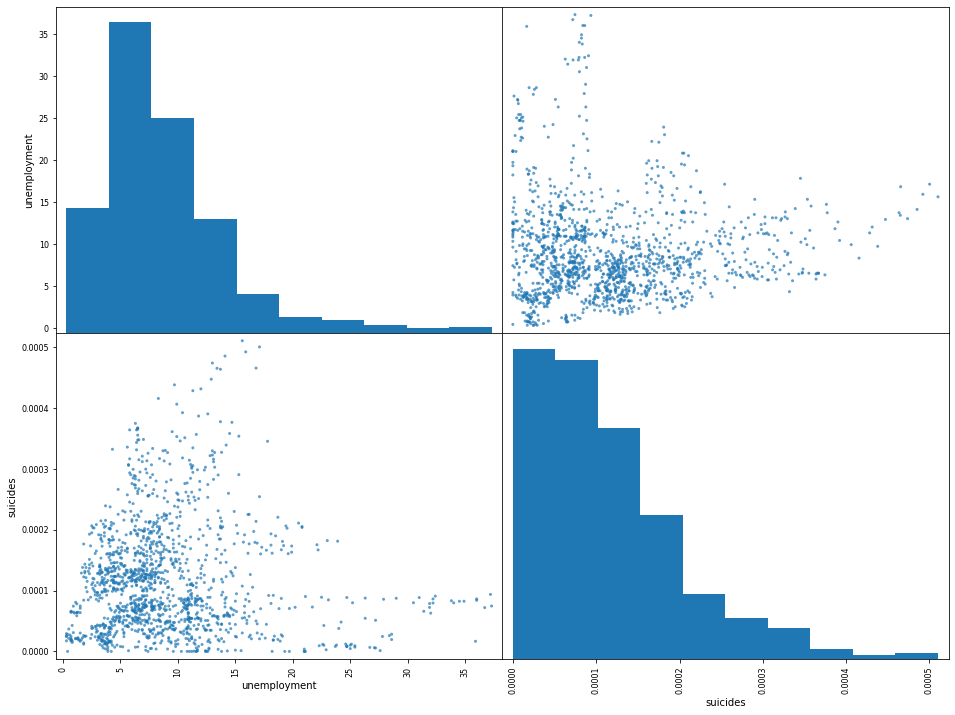

In [8]:
unemployment_data = data.copy()
unemployment_data['suicides'] = unemployment_data['suicides'] / unemployment_data['population']
pd.plotting.scatter_matrix(unemployment_data[['unemployment', 'suicides']], figsize=(16, 12), alpha=0.7)

### Split dataset

In [29]:
train_set, test_set = train_test_split(data, test_size=0.05, random_state=RANDOM_STATE)
train_set.head()

,cgd,cpi,gdp,unemployment,suicides,population
474,NaN,NaN,4.474670e+04,10.9,1919.0,21789067.0
1120,51.837325,97.579411,3.935150e+04,2.8,1439.0,15506963.0
107,76.431005,35.464103,1.852618e+06,9.9,3436.0,9737250.0
1591,NaN,111.987820,1.080988e+07,10.1,2126.0,44021800.0
993,8.909261,NaN,1.638701e+06,6.3,2659.0,9244456.0


### Preprocess entire dataset

In [38]:
# Define preprocessing pipeline
preprocessor = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('std_scaler', StandardScaler())#MinMaxScaler(feature_range=(0,1)))
])

# Define model
model = Ridge(alpha=1e-10)

In [31]:
train_X = train_set.drop("suicides", axis=1)
train_Y = train_set["suicides"].copy()

train_X_prepared = preprocessor.fit_transform(train_X)

In [32]:
test_X = test_set.drop("suicides", axis=1)
test_Y = test_set["suicides"].copy()

test_X_prepared = preprocessor.fit_transform(test_X)

# Model building

In [33]:
# Checking model errors with k-folds cross validation
scores = cross_val_score(model, train_X_prepared, train_Y, scoring="neg_median_absolute_error", cv=10)
lin_rmse_scores = np.sqrt(-scores)
display_scores(lin_rmse_scores)

Scores: [21.21928564 21.31148176 22.17348758 21.82797049 22.12342935 22.08335351
 21.96616312 21.25010468 21.91636263 22.18338321]
Mean: 21.80550219786491
Standard deviation: 0.3729967251566731


In [34]:
model.fit(train_X_prepared, train_Y)

Ridge(alpha=1e-10)

In [35]:
y_pred = model.predict(test_X_prepared)
mae = median_absolute_error(test_Y, y_pred)
mae

568.4017502670274